In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize

# Revisión inicial datos

Se tienen datos para 110 días, iniciando desde el 2025-01-12 00:00:00.


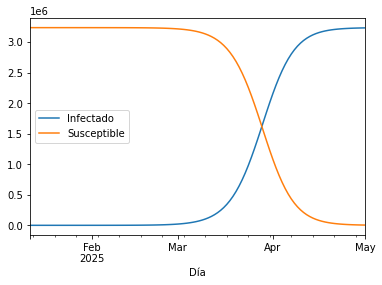

In [2]:
df = pd.read_excel("Propagación.xlsx")

# Conversión de fechas
df["Día"] = pd.to_datetime(df["Día"], format="%d/%m/%Y")
df["t_num"] = (df["Día"] - df["Día"].min()).dt.days + 1
print(f"""Se tienen datos para {len(df.t_num)} días, iniciando desde el {df["Día"][0]}.""")

# Definición de listado de valores para los modelos
t_obs = df["t_num"].values
infectado_obs = df["Infectado"].values
susceptible_obs = df["Susceptible"].values

df.set_index("Día")[["Infectado","Susceptible"]].plot();

Los datos dados serán ajustados según un modelo SI para poder obtener el beta de transición de susceptible a infectado.

Más adelante se usará otro modelo siguiendo el comportamiento descrito en el enunciado del problema. Ahí se usará este beta.

In [3]:
# Valores iniciales desde los datos para uso posterior
I0 = df['Infectado'].iloc[0]
S0 = df['Susceptible'].iloc[0]
N = I0 + S0 #población total

# Parámetros y definición de funciones

In [4]:
# Parámetros 
"""
Recuerde:
    S: Susceptibles
    A: Asintomáticos (infectados)
    Ic: Infectados en crisis
    L: Pos crisis con secuelas
    D: Fallecidos
"""

anios_a_simular = 10 #años

# tiempo en días para la infección y pos crisis con secuelas

T = {'A':  10, 
     'Ic': 2*7, 
     'L':  10*365  
}

# Calidad de vida en crisis para ningún tratamiento, tratamiento 1 o tratamiento 2
# del 100% (es decir 1) se resta el porcentaje de disminución en cada caso
Qc = {'Ninguno':1-0.35,
     't1': 1-0.12,
     't2': 1-0.50
}

# Calidad de vida con secuelas para tipos de tratamiento
QL = {'Ninguno':1-0.10,
     't1': 1-0.12,
     't2': 1-0.04
}

# Mortalidad en cada caso
M = {'Ninguno':0.15,
     't1': 0.03,
     't2': 0.15
}

In [5]:
def funcion_Qind(N,S,A,Ic,L,tratamiento="Ninguno"):
    """
    La función devuelve un indicador de calidad de vida para toda la población
    teniendo en cuenta:
    - N que corresponde a la población total,
    - y el número de personas en cada compartimento (S,A,Ic,L).
    Los fallecidos no se incluyen ya que su calidad de vida es nula.

    Estos valores cambian para cada tipo de tratamiento ("Ninguno","t1","t2").
        
    1*S + 1*A + Qc*Ic + QL*L
    
    Si no hubiera ningún infectado este indicador debería dar 1, correspondiente al 100%.
    Cuando hay infectados disminuye.
    """
    return 1/N*(
        S + A + Ic*Qc[tratamiento] + L*QL[tratamiento]
    )

In [6]:
def estimar_beta_si(df):
    """
    Estima el parámetro beta para un modelo SI (Susceptibles-Infectados) 
    usando ajuste a datos observados en un df con columnas:
    - 'Día' (datetime)
    - 'Susceptible'
    - 'Infectado'

    Devuelve el valor óptimo de beta.
    """

    from scipy.integrate import odeint
    from scipy.optimize import minimize
    import numpy as np

    # Asegurar tipo de fecha
    df = df.copy()
    df['Día'] = pd.to_datetime(df['Día'])
    df['t_num'] = (df['Día'] - df['Día'].min()).dt.days

    t_obs = df['t_num'].values
    I_obs = df['Infectado'].values
    S_obs = df['Susceptible'].values

    # Valores iniciales
    I0 = I_obs[0]
    S0 = S_obs[0]
    N = S0 + I0
    y0 = [S0, I0]

    # Modelo SI
    def deriv_si(y, t, N, beta):
        S, I = y
        dSdt = -beta * S * I / N
        dIdt = beta * S * I / N
        return [dSdt, dIdt]

    # Función objetivo
    def objective_si(params):
        beta = params[0]
        sol = odeint(deriv_si, y0, t_obs, args=(N, beta))
        _, I_sim = sol.T
        return np.mean((I_sim - I_obs)**2)

    # Optimización
    result = minimize(objective_si, [0.3], bounds=[(0.01, 1.0)], method='L-BFGS-B')
    beta_opt = result.x[0]

    return beta_opt

# Se estima el beta de los datos dados
beta_estimado = estimar_beta_si(df)
beta_estimado

0.18441405438663122

# Modelo SAIcLD

In [7]:
def simular_SAIcLD(
    N=3_000_000,
    A0=3,
    beta=0.2,
    duracion_A=10,
    duracion_Ic=7*2,
    duracion_L=365*10,
    delta=0.15,
    dias=365*10,
    estrategia=""
    
):
    """
    Simula una epidemia con compartimentos:
    S: Susceptibles
    A: Asintomáticos (infectados)
    Ic: Infectados en crisis (pueden morir)
    L: Pos crisis con secuelas (latentes antes de muerte o salida)
    D: Fallecidos

    Parámetros:
    - beta: tasa de transmisión desde A e Ic
    - duracion_A: duración promedio en estado A (días)
    - duracion_Ic: duración promedio en Ic
    - duracion_L: duración promedio en L (post-crisis)
    - delta: proporción que muere durante la fase Ic
    - dias: días totales a simular
    """

    # Estados iniciales
    S0 = N - A0
    Ic0 = 0
    L0 = 0
    D0 = 0
    y0 = [S0, A0, Ic0, L0, D0]

    # Tiempos y tasas
    t = np.linspace(0, dias, dias + 1)
    gamma_A = 1 / duracion_A
    gamma_Ic = 1 / duracion_Ic
    gamma_L = 1 / duracion_L

    def deriv(y, t, N, beta, gamma_A, gamma_Ic, gamma_L, delta):
        S, A, Ic, L, D = y
        infectados = A + Ic
        dSdt = -beta * S * infectados / N
        dAdt = beta * S * infectados / N - gamma_A * A
        dIcdt = gamma_A * A - gamma_Ic * Ic
        dLdt = gamma_Ic * (1 - delta) * Ic - gamma_L * L
        dDdt = gamma_Ic * delta * Ic + gamma_L * L
        return [dSdt, dAdt, dIcdt, dLdt, dDdt]

    result = odeint(deriv, y0, t, args=(N, beta, gamma_A, gamma_Ic, gamma_L, delta))
    S, A, Ic, L, D = result.T
    
    if estrategia != "":
        print("Estrategia:",estrategia)

    # Graficar resultados
    plt.figure(figsize=(12, 6))
    plt.plot(t, S, label='Susceptibles (S)')
    plt.plot(t, A, label='Asintomáticos (A)')
    plt.plot(t, Ic, label='En crisis (Ic)')
    plt.plot(t, L, label='Post-crisis con secuelas (L)')
    plt.plot(t, D, label='Fallecidos (D)')
    plt.xlabel('Días')
    plt.ylabel('Número de personas')
    plt.title('Modelo SAIcLD: evolución de la epidemia')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        't': t,
        'S': S,
        'A': A,
        'Ic': Ic,
        'L': L,
        'D': D
    }
    
    print("#######################")

# Escenarios

Estrategia: Sin tratamiento


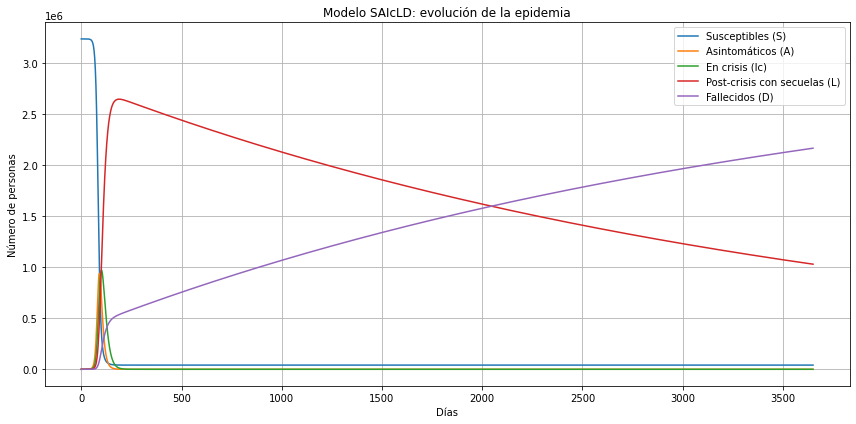

Estrategia: Tratamiento 1


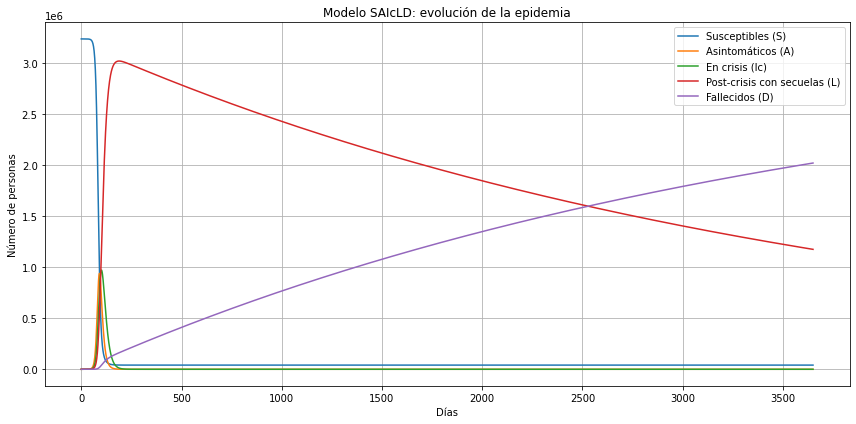

Estrategia: Tratamiento 2


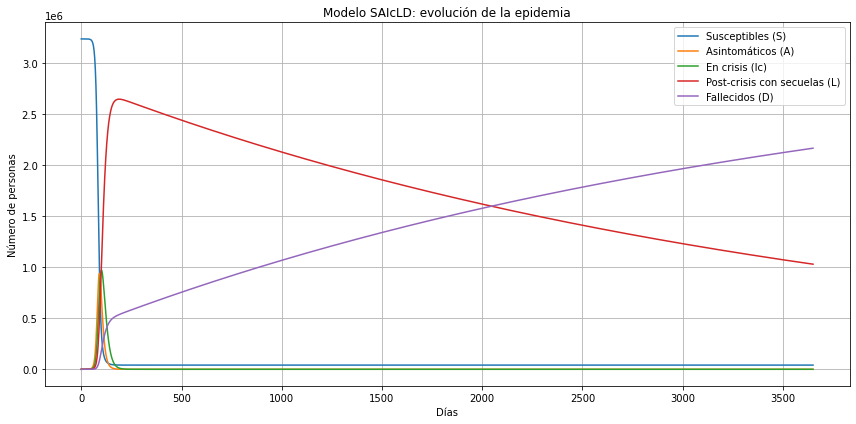

In [8]:
# Escenario 1: no hay tratamiento
t_nx,S_nx,A_nx,Ic_nx,L_nx,D_nx = (simular_SAIcLD(N=N,
    A0=I0,
    beta=beta_estimado,
    duracion_A=T['A'],
    duracion_Ic=T['Ic'],
    duracion_L=T['L'],
    delta=M['Ninguno'],
    dias=365*anios_a_simular,
    estrategia = "Sin tratamiento")).values()

# Escenario 2: tratamiento 1
t_t1,S_t1,A_t1,Ic_t1,L_t1,D_t1 = (simular_SAIcLD(N=N,
    A0=I0,
    beta=beta_estimado,
    duracion_A=T['A'],
    duracion_Ic=T['Ic'],
    duracion_L=T['L'],
    delta=M['t1'],
    dias=365*anios_a_simular,
    estrategia="Tratamiento 1")).values()

# Escenario 3: tratamiento 2 (en este caso es igual a sin tratamiento, tienen la misma mortalidad)
t_t2,S_t2,A_t2,Ic_t2,L_t2,D_t2 = (simular_SAIcLD(N=N,
    A0=I0,
    beta=beta_estimado,
    duracion_A=T['A'],
    duracion_Ic=T['Ic'],
    duracion_L=T['L'],
    delta=M['t2'],
    dias=365*anios_a_simular,
    estrategia="Tratamiento 2")).values()

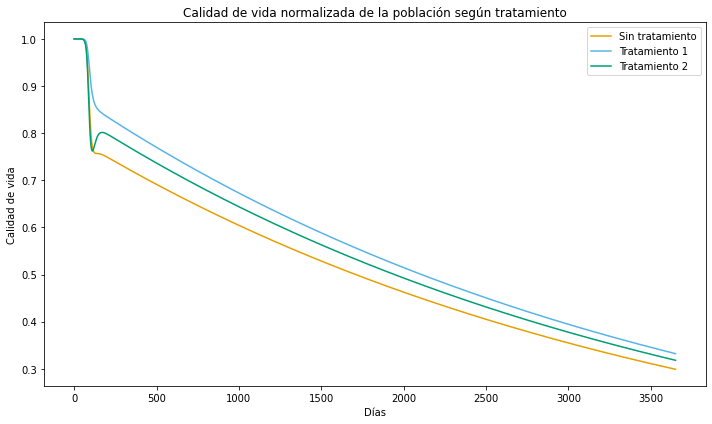

In [9]:
# Calidad de vida por días y tratamientos

x = list(range(len(D_nx)))
plt.figure(figsize=(10, 6))
plt.plot(x, funcion_Qind(N,S_nx,A_nx,Ic_nx,L_nx,tratamiento="Ninguno"), label='Sin tratamiento', color='#E69F00')
plt.plot(x, funcion_Qind(N,S_t1,A_t1,Ic_t1,L_t1,tratamiento="t1"), label='Tratamiento 1', color='#56B4E9')
plt.plot(x, funcion_Qind(N,S_t2,A_t2,Ic_t2,L_t2,tratamiento="t2"), label='Tratamiento 2', color='#009E73')
plt.title('Calidad de vida normalizada de la población según tratamiento')

plt.xlabel('Días')
plt.ylabel('Calidad de vida')
plt.legend()
plt.tight_layout()
plt.show()

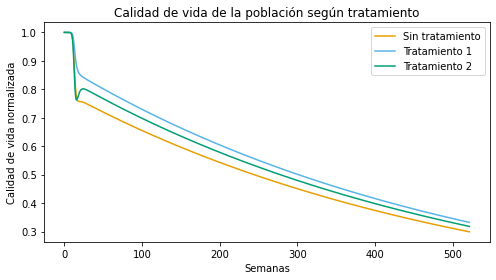

In [10]:
# Calidad de vida por semanas y tratamientos

x = list(range(len(D_nx)))
x_semanas = [i / 7 for i in x]  # convertir días → semanas

plt.figure(figsize=(7,4))
plt.plot(x_semanas, funcion_Qind(N,S_nx,A_nx,Ic_nx,L_nx,tratamiento="Ninguno"), label='Sin tratamiento', color='#E69F00')
plt.plot(x_semanas, funcion_Qind(N,S_t1,A_t1,Ic_t1,L_t1,tratamiento="t1"), label='Tratamiento 1', color='#56B4E9')
plt.plot(x_semanas, funcion_Qind(N,S_t2,A_t2,Ic_t2,L_t2,tratamiento="t2"), label='Tratamiento 2', color='#009E73')
plt.title('Calidad de vida de la población según tratamiento')

plt.xlabel('Semanas')
plt.ylabel('Calidad de vida normalizada')
plt.legend()
plt.tight_layout()

# Exportar a SVG
plt.savefig("images/python_calidad_vida_tratamientos.svg", format='svg')

# Mostrar en pantalla también (opcional)
plt.show()

In [11]:
#end :)